In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [3]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [4]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [5]:
def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights=None
    )
    modelInput.load_weights('/kaggle/input/weight/weights_mobilenet_v3_small_224_1.0_float_no_top.h5 10.36.54PM')
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [6]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'MobileNet.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint


In [7]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [8]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [9]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - MobileNetV3.h5")
    print("Model Saved!")

In [10]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [11]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [12]:
mpath = r'../input/multi-cancer/Multi Cancer/Multi Cancer'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 20
lr = 0.001

for i in classPaths:
    className = i
    print(className)
    

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]          

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
625/625 [==============================] - 207s 331ms/step - loss: 0.1254 - accuracy: 0.9669 - val_loss: 0.1024 - val_accuracy: 0.9732

Epoch 00002: val_loss improved from 0.15920 to 0.10242, saving model to Brain CancerMobileNet.h5
Epoch 3/20
625/625 [==============================] - 208s 333ms/step - loss: 0.0836 - accuracy: 0.9803 - val_loss: 0.0767 - val_accuracy: 0.9788

Epoch 00003: val_loss improved from 0.10242 to 0.07674, saving model to Brain CancerMobileNet.h5
Epoch 4/20
625/625 [==============================] - 208s 332ms/step - loss: 0.0625 - accuracy: 0.9862 - val_loss: 0.0587 - val_accuracy: 0.9862

Epoch 00004: val_loss improved from 0.07674 to 0.05873, saving model to Brain CancerMobileNet.h5
Epoch 5/20
625/625 [==============================] - 210s 336ms/step - loss: 0.0488 - accuracy: 0.9895 - val_loss: 0.0502 - val_accuracy: 0.9876

Epoch 00005: val_loss improved from 0.05873 to 0.05023, saving model to Brain CancerMobileNet.h5
Epoch 6/20
625/625 [====

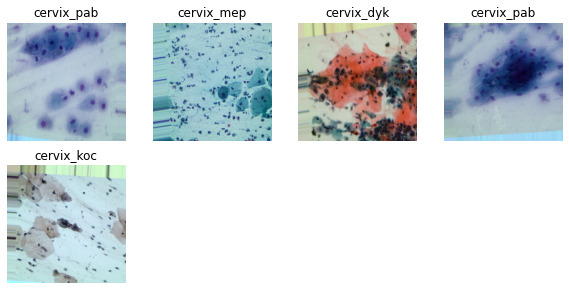

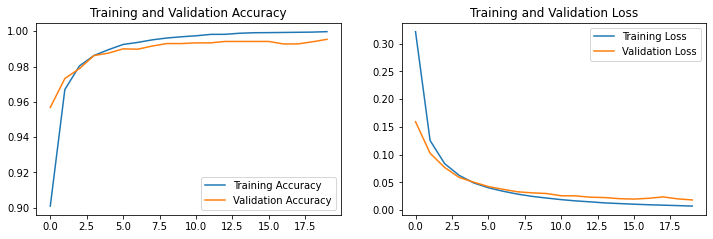

157/157 [==============================] - 42s 263ms/step - loss: 0.0182 - accuracy: 0.9954
Accuracy on the Test Set = 99.54 %
Model Saved!
True :  [0 0 0 ... 4 4 4]
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 432x288 with 0 Axes>

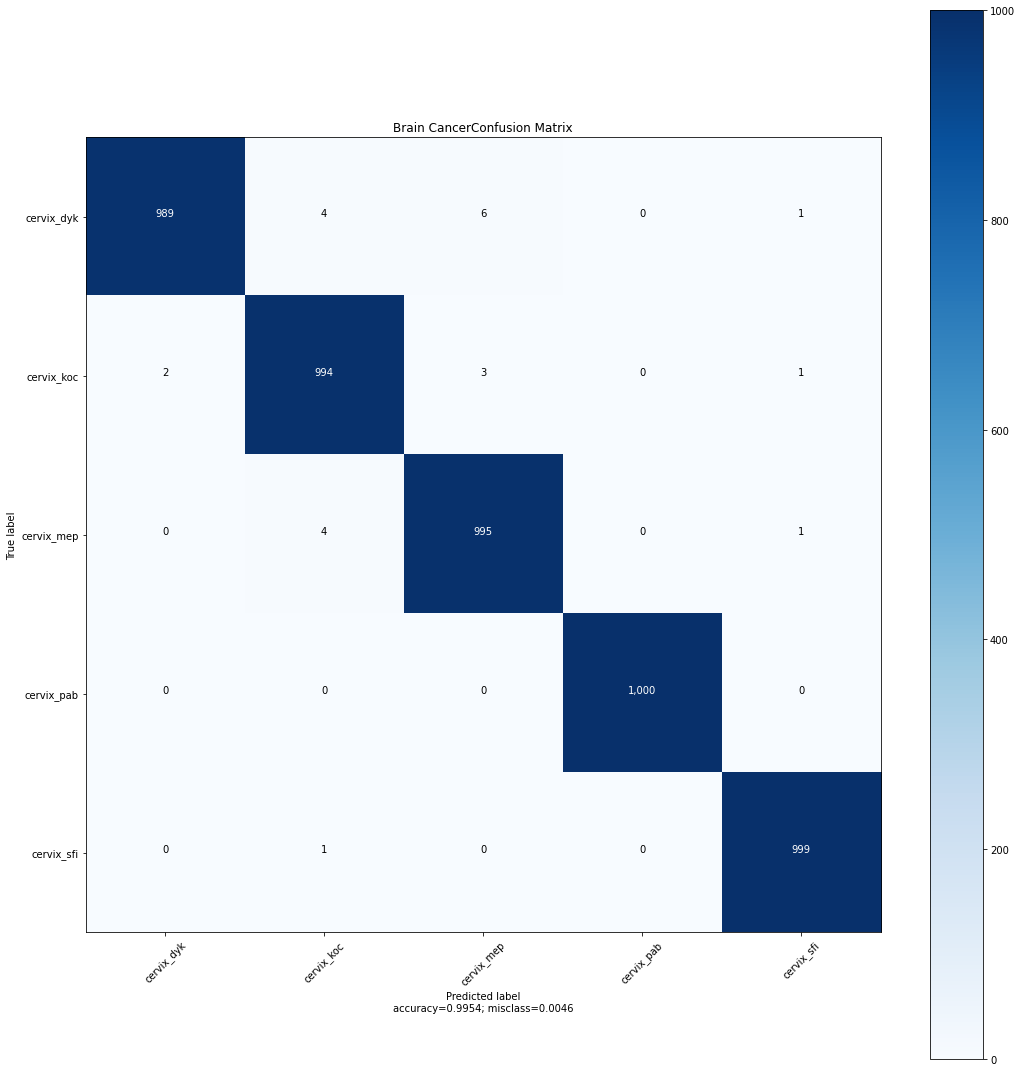

<Figure size 432x288 with 0 Axes>

In [15]:
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]              

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
625/625 [==============================] - 214s 342ms/step - loss: 0.0580 - accuracy: 0.9803 - val_loss: 0.0510 - val_accuracy: 0.9826

Epoch 00002: val_loss improved from 0.07217 to 0.05102, saving model to Brain CancerMobileNet.h5
Epoch 3/20
625/625 [==============================] - 215s 344ms/step - loss: 0.0424 - accuracy: 0.9856 - val_loss: 0.0404 - val_accuracy: 0.9874

Epoch 00003: val_loss improved from 0.05102 to 0.04042, saving model to Brain CancerMobileNet.h5
Epoch 4/20
625/625 [==============================] - 215s 343ms/step - loss: 0.0335 - accuracy: 0.9896 - val_loss: 0.0329 - val_accuracy: 0.9892

Epoch 00004: val_loss improved from 0.04042 to 0.03286, saving model to Brain CancerMobileNet.h5
Epoch 5/20
625/625 [==============================] - 211s 337ms/step - loss: 0.0272 - accuracy: 0.9918 - val_loss: 0.0284 - val_accuracy: 0.9926

Epoch 00005: val_loss improved from 0.03286 to 0.02838, saving model to Brain CancerMobileNet.h5
Epoch 6/20
625/625 [====

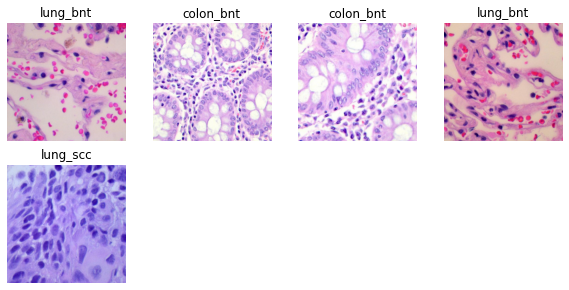

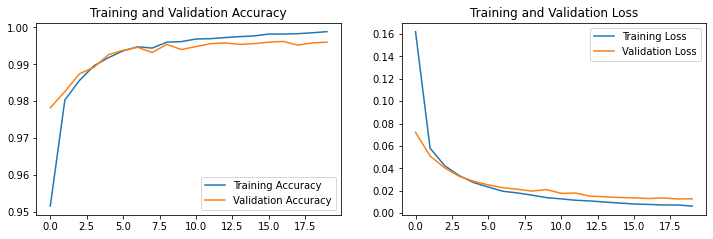

157/157 [==============================] - 42s 268ms/step - loss: 0.0128 - accuracy: 0.9960
Accuracy on the Test Set = 99.60 %
Model Saved!
True :  [0 0 0 ... 4 4 4]


In [ ]:
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 8002 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_2[0][0]                
_________________________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
251/251 [==============================] - 85s 340ms/step - loss: 0.3448 - accuracy: 0.8525 - val_loss: 0.3624 - val_accuracy: 0.8485

Epoch 00002: val_loss improved from 0.40306 to 0.36242, saving model to Brain CancerMobileNet.h5
Epoch 3/20
251/251 [==============================] - 88s 349ms/step - loss: 0.3107 - accuracy: 0.8680 - val_loss: 0.3461 - val_accuracy: 0.8545

Epoch 00003: val_loss improved from 0.36242 to 0.34611, saving model to Brain CancerMobileNet.h5
Epoch 4/20
251/251 [==============================] - 86s 341ms/step - loss: 0.2861 - accuracy: 0.8845 - val_loss: 0.3301 - val_accuracy: 0.8590

Epoch 00004: val_loss improved from 0.34611 to 0.33005, saving model to Brain CancerMobileNet.h5
Epoch 5/20
251/251 [==============================] - 85s 339ms/step - loss: 0.2728 - accuracy: 0.8905 - val_loss: 0.3447 - val_accuracy: 0.8585

Epoch 00005: val_loss did not improve from 0.33005
Epoch 6/20
251/251 [==============================] - 85s 337ms/step - los

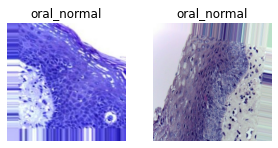

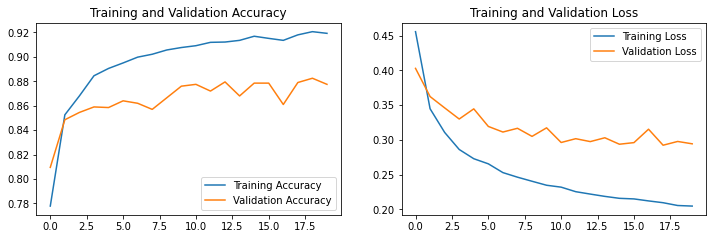

63/63 [==============================] - 17s 262ms/step - loss: 0.2943 - accuracy: 0.8775
Accuracy on the Test Set = 87.75 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

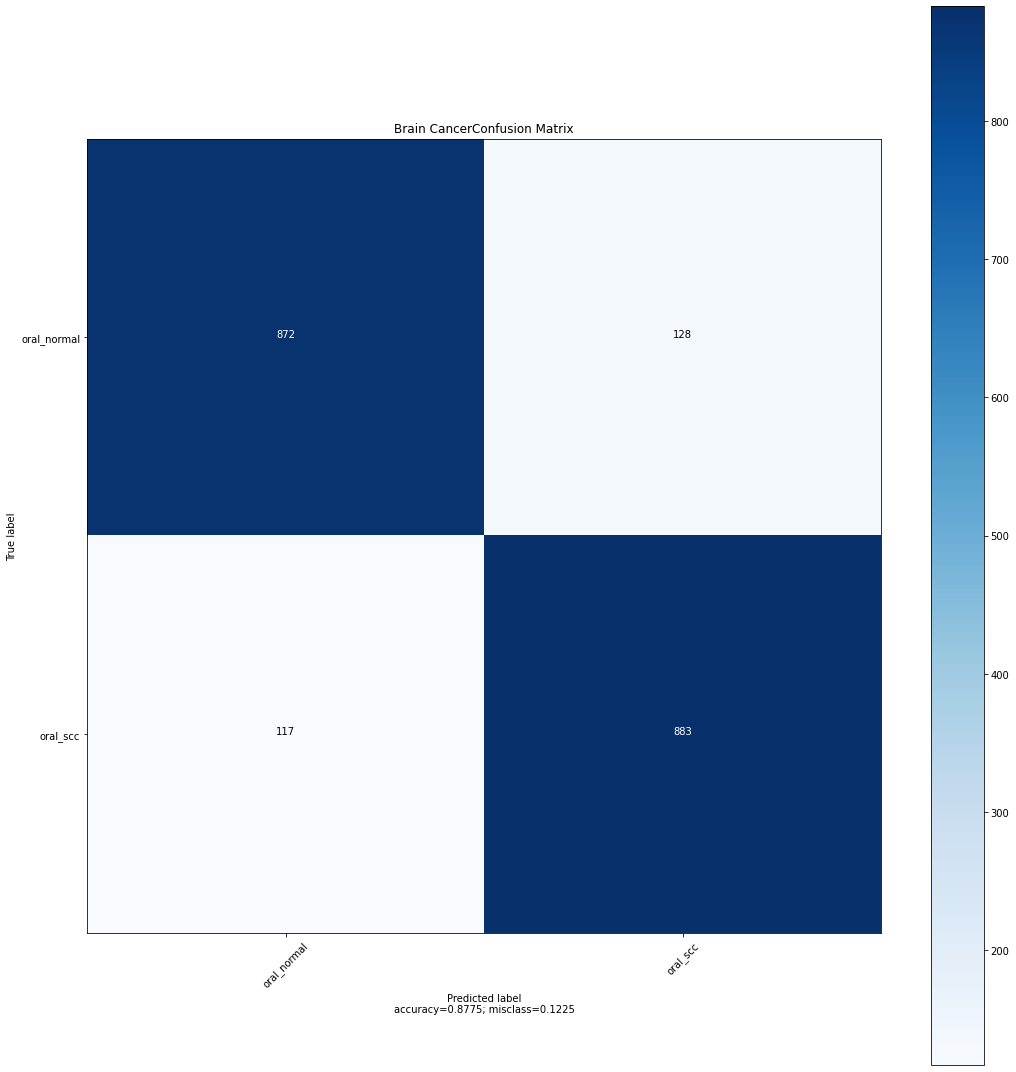

<Figure size 432x288 with 0 Axes>

In [17]:
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_3[0][0]                
___________________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
250/250 [==============================] - 81s 323ms/step - loss: 0.0696 - accuracy: 0.9920 - val_loss: 0.1130 - val_accuracy: 0.9640

Epoch 00002: val_loss improved from 0.15412 to 0.11299, saving model to Kidney Cancer MobileNet.h5
Epoch 3/20
250/250 [==============================] - 79s 316ms/step - loss: 0.0406 - accuracy: 0.9971 - val_loss: 0.1405 - val_accuracy: 0.9425

Epoch 00003: val_loss did not improve from 0.11299
Epoch 4/20
250/250 [==============================] - 79s 315ms/step - loss: 0.0272 - accuracy: 0.9986 - val_loss: 0.0975 - val_accuracy: 0.9590

Epoch 00004: val_loss improved from 0.11299 to 0.09749, saving model to Kidney Cancer MobileNet.h5
Epoch 5/20
250/250 [==============================] - 79s 314ms/step - loss: 0.0205 - accuracy: 0.9991 - val_loss: 0.1004 - val_accuracy: 0.9570

Epoch 00005: val_loss did not improve from 0.09749
Epoch 6/20
250/250 [==============================] - 78s 313ms/step - loss: 0.0153 - accuracy: 0.9994 - val_loss: 0

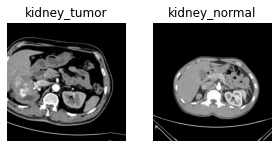

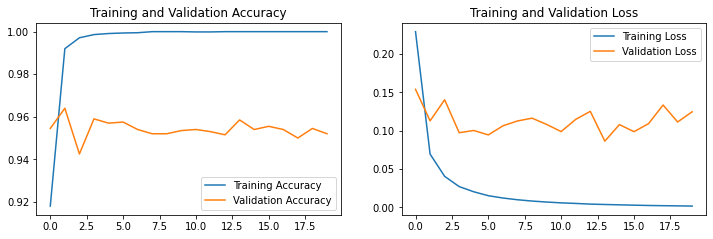

63/63 [==============================] - 15s 241ms/step - loss: 0.1248 - accuracy: 0.9520
Accuracy on the Test Set = 95.20 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

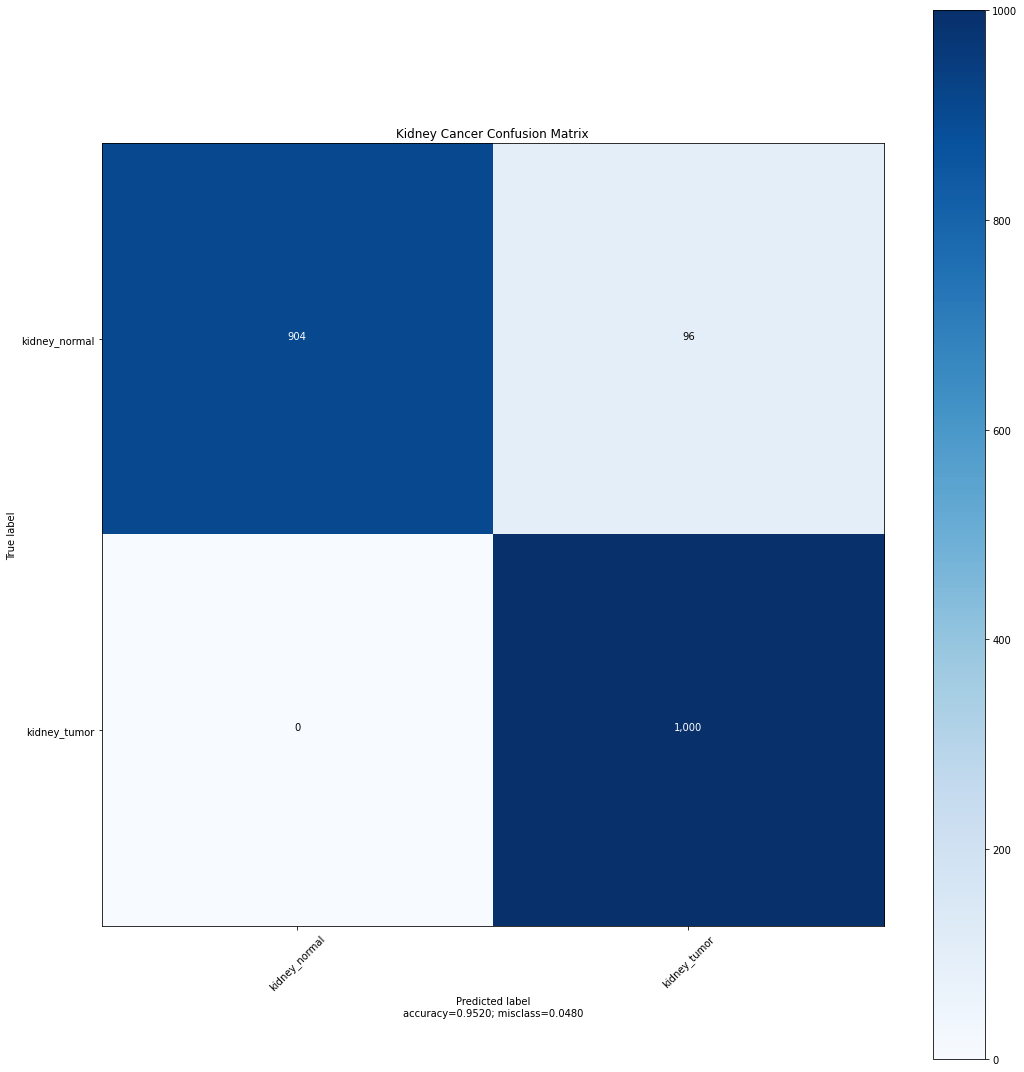

<Figure size 432x288 with 0 Axes>

In [18]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_5 (Rescaling)         (None, 224, 224, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_5[0][0]                
_______________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
250/250 [==============================] - 145s 582ms/step - loss: 0.0359 - accuracy: 0.9908 - val_loss: 0.0551 - val_accuracy: 0.9815

Epoch 00002: val_loss improved from 0.06562 to 0.05512, saving model to Breast Cancer MobileNet.h5
Epoch 3/20
250/250 [==============================] - 117s 466ms/step - loss: 0.0272 - accuracy: 0.9935 - val_loss: 0.0513 - val_accuracy: 0.9820

Epoch 00003: val_loss improved from 0.05512 to 0.05133, saving model to Breast Cancer MobileNet.h5
Epoch 4/20
250/250 [==============================] - 115s 461ms/step - loss: 0.0228 - accuracy: 0.9944 - val_loss: 0.0465 - val_accuracy: 0.9840

Epoch 00004: val_loss improved from 0.05133 to 0.04653, saving model to Breast Cancer MobileNet.h5
Epoch 5/20
250/250 [==============================] - 115s 458ms/step - loss: 0.0189 - accuracy: 0.9951 - val_loss: 0.0504 - val_accuracy: 0.9795

Epoch 00005: val_loss did not improve from 0.04653
Epoch 6/20
250/250 [==============================] - 114s 457ms

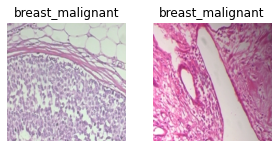

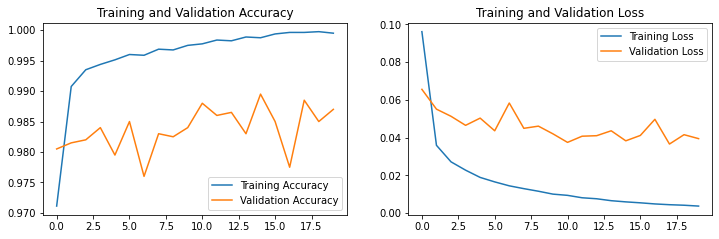

63/63 [==============================] - 23s 358ms/step - loss: 0.0395 - accuracy: 0.9870
Accuracy on the Test Set = 98.70 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 432x288 with 0 Axes>

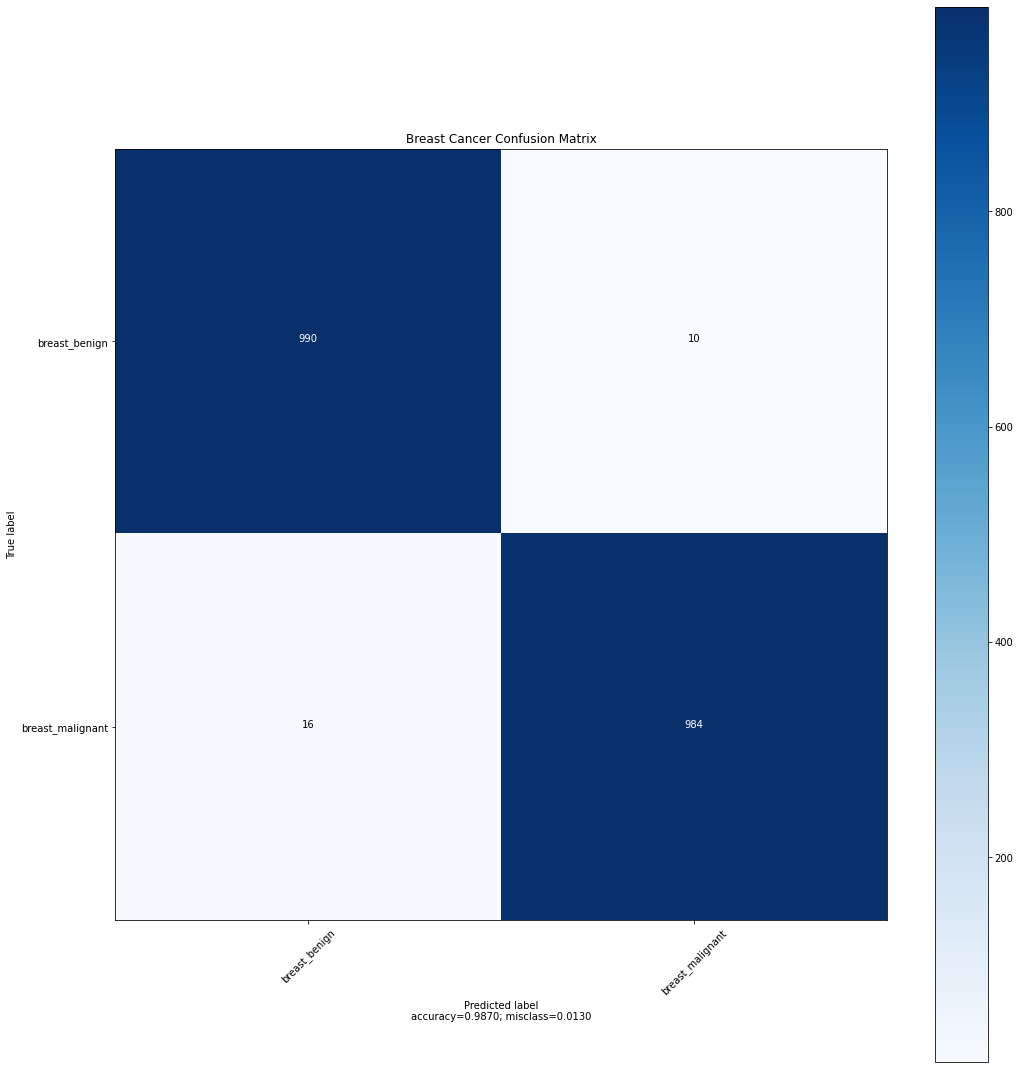

<Figure size 432x288 with 0 Axes>

In [20]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_4[0][0]                
_____________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
375/375 [==============================] - 158s 422ms/step - loss: 0.5623 - accuracy: 0.7714 - val_loss: 0.5320 - val_accuracy: 0.7880

Epoch 00002: val_loss improved from 0.62056 to 0.53198, saving model to Lymphoma MobileNet.h5
Epoch 3/20
375/375 [==============================] - 139s 372ms/step - loss: 0.4987 - accuracy: 0.8016 - val_loss: 0.4971 - val_accuracy: 0.8003

Epoch 00003: val_loss improved from 0.53198 to 0.49705, saving model to Lymphoma MobileNet.h5
Epoch 4/20
375/375 [==============================] - 145s 387ms/step - loss: 0.4606 - accuracy: 0.8186 - val_loss: 0.4607 - val_accuracy: 0.8197

Epoch 00004: val_loss improved from 0.49705 to 0.46073, saving model to Lymphoma MobileNet.h5
Epoch 5/20
375/375 [==============================] - 142s 377ms/step - loss: 0.4322 - accuracy: 0.8320 - val_loss: 0.4430 - val_accuracy: 0.8243

Epoch 00005: val_loss improved from 0.46073 to 0.44296, saving model to Lymphoma MobileNet.h5
Epoch 6/20
375/375 [================

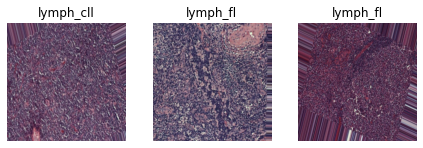

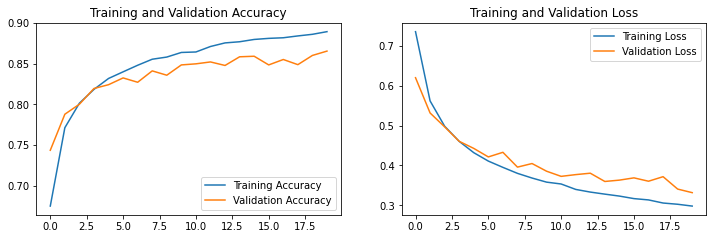

94/94 [==============================] - 28s 292ms/step - loss: 0.3318 - accuracy: 0.8657
Accuracy on the Test Set = 86.57 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 432x288 with 0 Axes>

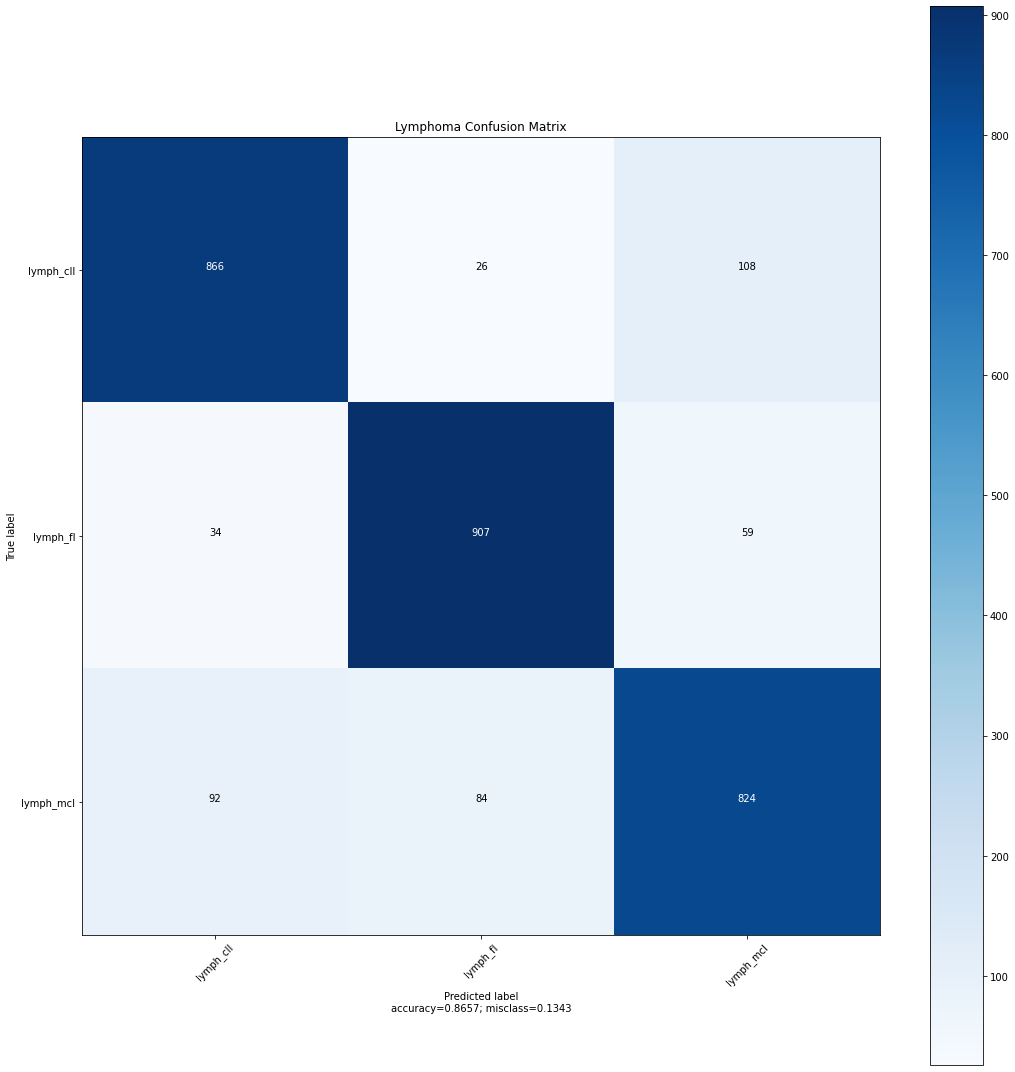

<Figure size 432x288 with 0 Axes>

In [19]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
_______________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


375/375 [==============================] - 75s 201ms/step - loss: 0.1732 - accuracy: 0.9454 - val_loss: 0.1577 - val_accuracy: 0.9423

Epoch 00002: val_loss improved from 0.19726 to 0.15768, saving model to Brain Cancer MobileNet.h5
Epoch 3/20
375/375 [==============================] - 75s 200ms/step - loss: 0.1392 - accuracy: 0.9532 - val_loss: 0.1344 - val_accuracy: 0.9490

Epoch 00003: val_loss improved from 0.15768 to 0.13437, saving model to Brain Cancer MobileNet.h5
Epoch 4/20
375/375 [==============================] - 74s 198ms/step - loss: 0.1205 - accuracy: 0.9615 - val_loss: 0.1241 - val_accuracy: 0.9543

Epoch 00004: val_loss improved from 0.13437 to 0.12408, saving model to Brain Cancer MobileNet.h5
Epoch 5/20
375/375 [==============================] - 74s 198ms/step - loss: 0.1069 - accuracy: 0.9664 - val_loss: 0.1097 - val_accuracy: 0.9607

Epoch 00005: val_loss improved from 0.12408 to 0.10969, saving model to Brain Cancer MobileNet.h5
Epoch 6/20
375/375 [===============

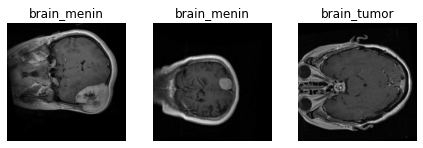

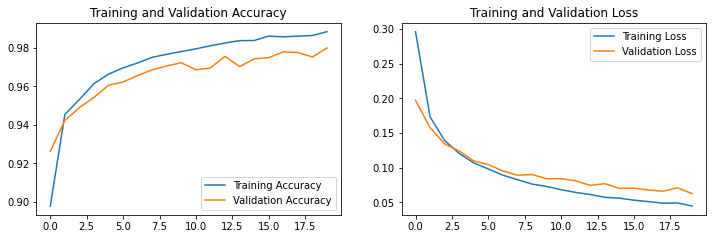

94/94 [==============================] - 15s 155ms/step - loss: 0.0625 - accuracy: 0.9800
Accuracy on the Test Set = 98.00 %
Model Saved!
True :  [0 0 0 ... 2 2 2]
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 432x288 with 0 Axes>

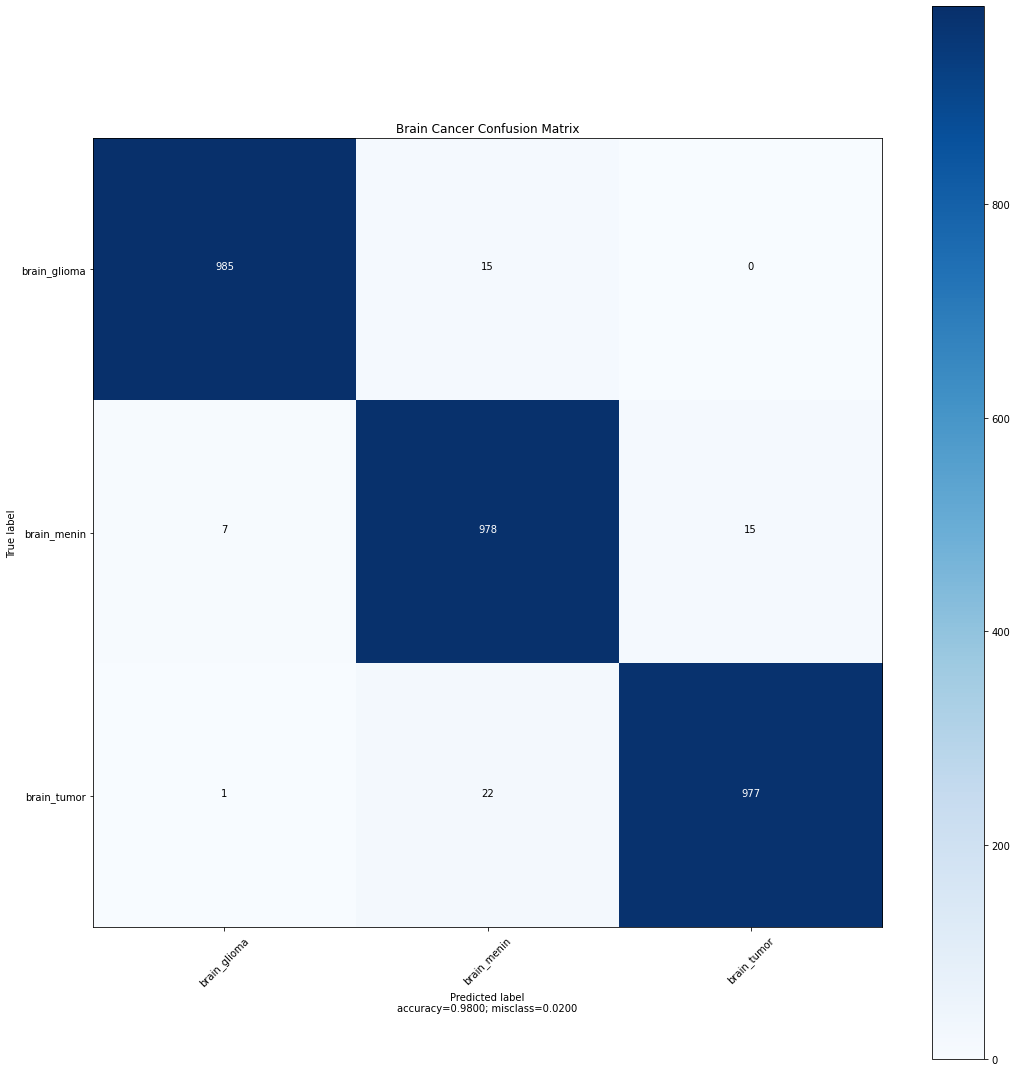

<Figure size 432x288 with 0 Axes>

In [13]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, epochs=gEpochs, batchSize=256)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to load the model from the saved .h5 file
def load_trained_model(model_path):
    model = tf.keras.models.load_model(model_path)
    print(f"Model loaded from {model_path}")
    return model

# Function to preprocess the image for MobileNetV3
def preprocess_input_image(img_path, target_size=(224, 224)):
    # Load the image and resize it to the target size
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert image to numpy array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to make it a batch of size 1
    img_array = np.expand_dims(img_array, axis=0)
    
    # Normalize the image
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    
    return img_array

# Function to predict the class of the image
def predict_image(model, img_path, class_names):
    # Preprocess the input image
    img_array = preprocess_input_image(img_path)
    
    # Make prediction
    predictions = model.predict(img_array)
    
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions[0])
    
    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]
    
    # Print the result
    print(f"Predicted Class: {predicted_class_name}")
    print(f"Prediction Confidence: {predictions[0][predicted_class_index]:.5f}")

    # Optionally, visualize the input image
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Example Usage:
model_path = "/kaggle/working/Brain CancerMobileNet.h5"  # Path to your saved model
img_path = "/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Breast Cancer/breast_benign/breast_benign_0001.jpg"  # Path to the image you want to predict

# Load the model
model = load_trained_model(model_path)

# Provide the class names (use the same list as the one used in training)
# For example:
class_names = ["class_1", "class_2", "class_3", "class_4", "class_5"]  # Replace with actual class names

# Make a prediction
predict_image(model, img_path, class_names)